# Load data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import warnings

warnings.filterwarnings("ignore")

In [2]:
JSON_PATH = "./out/past_product_info.json"

product_info = pd.read_json(JSON_PATH)
product_info["ended_on"] = pd.to_datetime(product_info["ended_on"], format="%B %d, %Y")

# Older entries have the format "N of N" that need to be cast to int("N")
product_info["n_sold"] = product_info["n_sold"].apply(lambda x: int(x.split()[0]))

# Removing % from percent_funded
product_info["percent_funded"] = product_info["percent_funded"].apply(
    lambda x: np.nan if x is None else int(x.strip("%"))
)

## Descriptive statistics

In [3]:
def get_general(df, YEAR):
    """Get info about number of creators, campaigns, and total products sold."""
    n_creators = df["creator_name"].nunique()
    n_campaigns = df.groupby(["plush_name", "creator_name"]).ngroups
    total_sold = df["n_sold"].sum()

    print(
        f"""
    Year examined: {YEAR}
        - Number of creators: {n_creators}
        - Number of campaigns: {n_campaigns}
        - Total number of plushies sold: {total_sold:,}
    """
    )

In [4]:
import matplotlib.patheffects as path_effects


def add_median_labels(ax):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == "PathPatch"]
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4 : len(lines) : lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(
            x,
            y,
            f"{value:,.0f}",
            ha="center",
            va="center",
            fontweight="bold",
            color="white",
            size=8,
        )
        # create median-colored border around white text for contrast
        text.set_path_effects(
            [
                path_effects.Stroke(linewidth=3, foreground=median.get_color()),
                path_effects.Normal(),
            ]
        )

In [5]:
def get_top_creators(df, TOP_N):
    """Get top N creators based on total plushies sold (barplot) and
    the distribution of the campaign performance for each
    creator (boxplot)."""
    #####################
    # Setting up df filters
    #####################

    # Get total plushies sold associated with each creator
    print(
        f"Selecting the top {TOP_N} creators based on total plushies sold for selected year:"
    )
    top_creators = (
        df[["creator_name", "plush_name", "n_sold"]]
        .groupby("creator_name")
        .agg(sum)
        .sort_values("n_sold", ascending=False)
        .head(TOP_N)
        .reset_index()
    )
    top_creators.columns = ["Creator", "Total sold"]

    # Get all campaigns associated with the top_n creators
    all_top_creator_campaigns = df[df["creator_name"].isin(top_creators["Creator"])][
        ["creator_name", "n_sold"]
    ]
    all_top_creator_campaigns.columns = ["Creator", "Amount sold per campaign"]

    #####################
    # Plotting
    #####################
    fig, axes = plt.subplots(1, 2, figsize=(15, 0.5 * TOP_N), sharey=True)

    # display(top_creators)
    # display(all_top_creator_campaigns)

    # Graph total plushies sold for each creator
    ax = sns.barplot(data=top_creators, x="Total sold", y="Creator", ax=axes[0])
    ax.bar_label(
        ax.containers[0],
        padding=-40,
        labels=[f"{x:,.0f}" for x in ax.containers[0].datavalues],
        path_effects=[
            path_effects.Stroke(linewidth=3, foreground="#3d3d3d"),
            path_effects.Normal(),
        ],
        color="white",
        fontweight="bold",
        size=8,
    )

    ax2 = sns.boxplot(
        data=all_top_creator_campaigns,
        x="Amount sold per campaign",
        y="Creator",
        ax=axes[1],
        order=top_creators["Creator"],
    )
    add_median_labels(ax2)

    for ax in fig.axes:
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

    plt.show()

In [6]:
def get_monthly_distribution(df):
    """Get the total plushy sales for each month and
    the distribution of those sales each month."""
    #####################
    # Setup
    #####################
    months = [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ]
    df["Month"] = df["ended_on"].dt.strftime("%b")

    # Get the highest quartile (used for setting y limit)
    max_075_quantile = max(
        df.groupby("Month").agg(lambda x: x.quantile(0.75)).reset_index()["n_sold"]
    )

    #####################
    # Plotting
    #####################
    print("Plotting plushies sold per month and monthly distribution:")
    fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

    ax = sns.barplot(
        data=df,
        y="Month",
        x="n_sold",
        ax=axes[0],
        order=months,
        estimator="sum",
        ci=None,
    )
    ax.bar_label(
        ax.containers[0],
        padding=-40,
        labels=[f"{x:,.0f}" for x in ax.containers[0].datavalues],
        path_effects=[
            path_effects.Stroke(linewidth=3, foreground="#3d3d3d"),
            path_effects.Normal(),
        ],
        color="white",
        fontweight="bold",
        size=8,
    )

    ax2 = sns.boxplot(
        data=df, y="Month", x="n_sold", order=months, showfliers=False, ax=axes[1]
    )
    sns.stripplot(
        data=df,
        y="Month",
        x="n_sold",
        order=months,
        alpha=0.5,
        dodge=True,
        color=".2",
        size=4,
        ax=axes[1],
    )
    add_median_labels(ax2)

    for ax in fig.axes:
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

    plt.show()


    Year examined: 2022
        - Number of creators: 419
        - Number of campaigns: 527
        - Total number of plushies sold: 391,818
    
Selecting the top 8 creators based on total plushies sold for selected year:


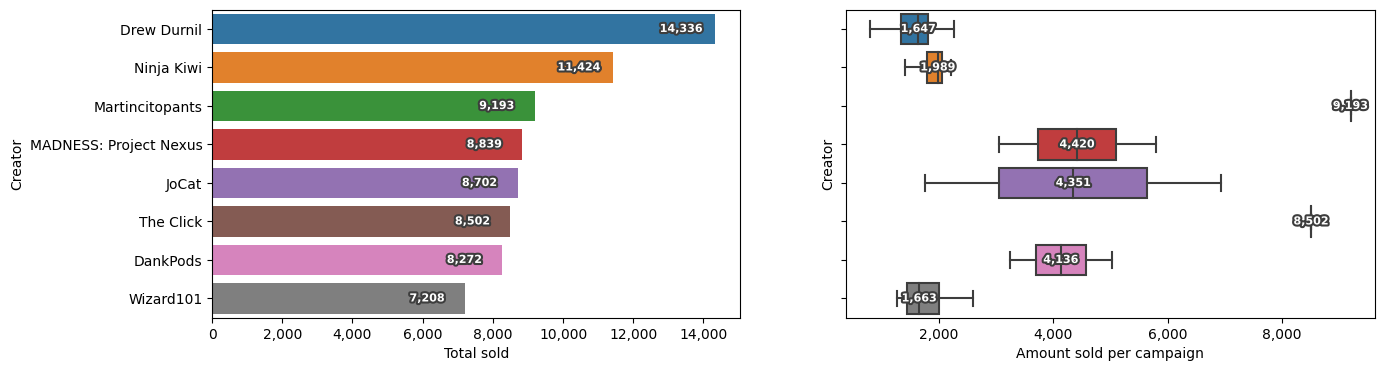

Plotting plushies sold per month and monthly distribution:


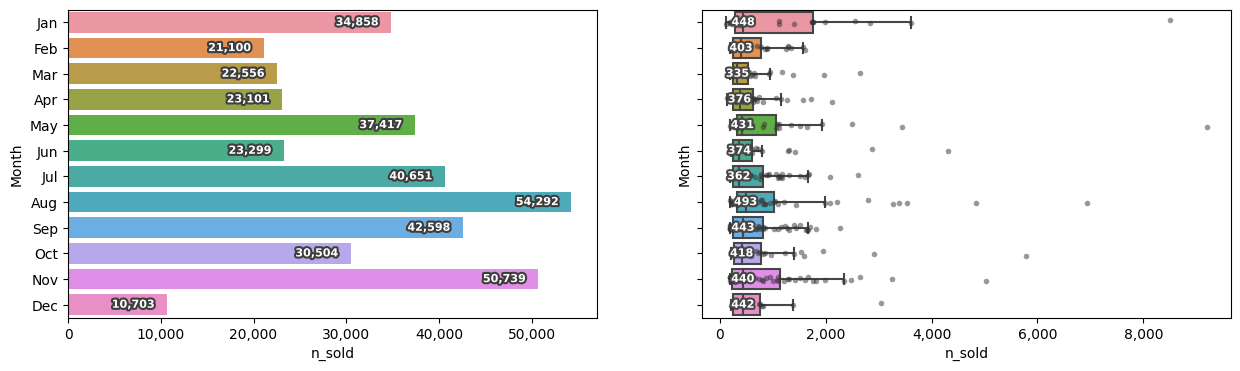

In [7]:
def filter_df(df, YEAR):
    if isinstance(YEAR, int):
        return df[df["ended_on"].dt.year == YEAR]
    return df


def run():
    # Setup variables
    # Number of entries to show when truncating results
    TOP_N = 8

    # None indicates all years should be included
    YEAR_OPTIONS = [2020, 2021, 2022, "all"]
    YEAR = YEAR_OPTIONS[2]  # 2022

    ########################

    filtered_df = filter_df(product_info, YEAR)
    filtered_df.sort_values("n_sold", ascending=False).head()

    get_general(filtered_df, YEAR)
    get_top_creators(filtered_df, TOP_N)
    get_monthly_distribution(filtered_df)


run()